In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [64]:
def initialize_weights(shape, init='default', fan_in=None, fan_out=None):
    if init == 'xavier':
        # Xavier: sử dụng giới hạn cho phân phối uniform
        limit = np.sqrt(6 / (fan_in + fan_out))
        return np.random.uniform(-limit, limit, shape)
    elif init == 'he':
        # He: chuẩn độ lệch = sqrt(2/fan_in)
        std = np.sqrt(2 / fan_in)
        return np.random.randn(*shape) * std
    else:
        # Mặc định: khởi tạo với std nhỏ
        return np.random.randn(*shape) * 0.01


In [65]:
def padding(x, padding: int | tuple | list, padding_type='zero'):
    assert padding_type in ['zero', 'reflect', 'edge', 'symmetric']
    if isinstance(padding, int):
        padding = (padding, padding)
    if padding_type == 'zero':
        return np.pad(x, ((0, 0), (0, 0), (padding[0], padding[0]), (padding[1], padding[1])),
                      'constant', constant_values=0)
    else:
        return np.pad(x, ((0, 0), (0, 0), (padding[0], padding[0]), (padding[1], padding[1])), padding_type)

def dilation(x, dilation: int | tuple | list):
    if isinstance(dilation, int):
        dilation = (dilation, dilation)
    if dilation == 0:
        return x
    size = x.shape
    h_out = size[2] + (size[2]-1) * dilation[0]
    w_out = size[3] + (size[3]-1) * dilation[1]
    out = np.zeros((size[0], size[1], h_out, w_out))
    pad = dilation[0] + 1
    for i in range(size[2]):
        for j in range(size[3]):
            out[:, :, i*pad, j*pad] = x[:, :, i, j]
    return out

In [66]:
class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size: int | list | tuple,
                 stride=1, padding=0, padding_type='edge', is_bias=True, init='xavier'):
        self.in_channels = in_channels
        self.out_channels = out_channels
        assert isinstance(kernel_size, (int, list, tuple))
        if isinstance(kernel_size, (tuple, list)):
            assert len(kernel_size) == 2
            self.kernel_size = kernel_size
        else:
            self.kernel_size = (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.padding_type = padding_type
        self.training = True
        self.input = None
        self.w_grad = None
        self.b_grad = None

        # Tính fan_in và fan_out cho lớp Conv2d
        fan_in = in_channels * self.kernel_size[0] * self.kernel_size[1]
        fan_out = out_channels * self.kernel_size[0] * self.kernel_size[1]
        # Khởi tạo trọng số theo phương pháp được chọn
        self.weights = initialize_weights((out_channels, in_channels, self.kernel_size[0], self.kernel_size[1]),
                                          init=init, fan_in=fan_in, fan_out=fan_out)
        self.bias = np.random.randn(out_channels) if is_bias else None

    def forward(self, x):
        if len(x.shape) == 3:
            x = np.expand_dims(x, axis=0)
        x = padding(x, self.padding, self.padding_type)
        if self.training:
            self.input = x
        batch_size, in_channels, height, width = x.shape
        assert in_channels == self.in_channels
        out = self._calculate_conv2d(x, self.weights, self.bias)
        return out

    def _calculate_conv2d(self, x, kernel, bias=None):
        batch, in_channels, height, width = x.shape
        out_channels, _, k_h, k_w = kernel.shape

        out_height = (height - k_h) // self.stride + 1
        out_width = (width - k_w) // self.stride + 1

        size = [batch, out_channels, out_height, out_width]
        out = np.zeros(size)

        kernel = np.expand_dims(kernel, axis=0)
        input_exp = np.expand_dims(x, axis=1)

        kernel = np.repeat(kernel, repeats=size[0], axis=0)
        input_exp = np.repeat(input_exp, repeats=size[1], axis=1)

        for i in range(out_height):
            for j in range(out_width):
                h = i * self.stride
                w = j * self.stride
                out[:, :, i, j] = np.sum(input_exp[:, :, :, h:h+k_h, w:w+k_w] * kernel, axis=(-1, -2, -3))
        if bias is not None:
            bias = bias.reshape(1, self.out_channels, 1, 1)
            out += bias
        return out

    def backward(self, grad_output):
        assert self.input is not None
        x = np.transpose(self.input, (1, 0, 2, 3))
        kernel_back_w = np.transpose(grad_output, (1, 0, 2, 3))
        kernel_back_w = dilation(kernel_back_w, self.stride-1)
        w_grad = self._calculate_conv2d(x, kernel_back_w)
        w_grad = np.transpose(w_grad, (1, 0, 2, 3))
        b_grad = np.sum(grad_output, axis=(0, 2, 3))
        self.w_grad = w_grad
        self.b_grad = b_grad
        w = np.transpose(self.weights, (1, 0, 2, 3))
        dilation_out = dilation(grad_output, self.stride-1)
        padding_grad_output = padding(dilation_out, (w.shape[2]-1, w.shape[3]-1))
        grad_input = self._calculate_conv2d(padding_grad_output, w[:, :, ::-1, ::-1])
        if self.padding > 0:
            grad_input = grad_input[:, :, self.padding:-self.padding, self.padding:-self.padding]
        return grad_input

    def update(self, lr):
        if self.w_grad is None or self.b_grad is None:
            return
        self.weights -= lr * self.w_grad
        if self.bias is not None:
            self.bias -= lr * self.b_grad

    def zero_grad(self):
        self.w_grad = None
        self.b_grad = None

    def eval(self):
        self.training = False

    def train(self):
        self.training = True

    def __call__(self, x):
        return self.forward(x)


In [67]:
class MaxPool2d:
    def __init__(self, kernel_size: int | list | tuple, stride=2, padding=0, padding_type='edge'):
        if isinstance(kernel_size, (tuple, list)):
            assert len(kernel_size) == 2
            self.kernel_size = kernel_size
        else:
            self.kernel_size = (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.padding_type = padding_type
        self.input = None

    def forward(self, x):
        if len(x.shape) == 3:
            x = np.expand_dims(x, axis=0)
        x = padding(x, self.padding, self.padding_type)
        self.input = x
        out = self._calculate_maxpool2d(x)
        return out

    def _calculate_maxpool2d(self, x):
        batch, in_channels, height, width = x.shape
        out_height = (height - self.kernel_size[0]) // self.stride + 1
        out_width = (width - self.kernel_size[1]) // self.stride + 1
        size = [batch, in_channels, out_height, out_width]
        out = np.zeros(size)
        for i in range(out_height):
            for j in range(out_width):
                h = i * self.stride
                w = j * self.stride
                out[:, :, i, j] = np.max(x[:, :, h:h+self.kernel_size[0], w:w+self.kernel_size[1]], axis=(-1, -2))
        return out

    def backward(self, grad_output):
        assert self.input is not None
        x = self.input
        grad_input = np.zeros(x.shape)
        size = grad_output.shape
        for i in range(size[2]):
            for j in range(size[3]):
                h = i * self.stride
                w = j * self.stride
                x_slice = x[:, :, h:h+self.kernel_size[0], w:w+self.kernel_size[1]]
                max_val = np.max(x_slice, axis=(-1, -2), keepdims=True)
                mask = (x_slice == max_val).astype(int)
                grad = grad_output[:, :, i, j][:, :, None, None]
                grad_input[:, :, h:h+self.kernel_size[0], w:w+self.kernel_size[1]] += mask * grad
        if self.padding > 0:
            grad_input = grad_input[:, :, self.padding:-self.padding, self.padding:-self.padding]
        return grad_input

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        pass

    def train(self):
        pass

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

In [68]:
class Linear:
    def __init__(self, in_features, out_features, init = 'deafalut'):
        # Correct the weight initialization: (out_features, in_features)
        self.weight = initialize_weights((out_features, in_features),
                                           init=init,
                                           fan_in=in_features,
                                           fan_out=out_features)
        self.bias = np.zeros((out_features, 1))
        self.training = True
        self.input = None
        self.w_grad = None
        self.b_grad = None

    def forward(self, x):
        if self.training:
            self.input = x
        return np.dot(x, self.weight.T) + self.bias.T

    def backward(self, out_grad):
        x = self.input
        self.w_grad = np.dot(x.T, out_grad)
        self.b_grad = np.sum(out_grad, axis=0, keepdims=True)
        return np.dot(out_grad, self.weight)

    def update(self, lr):
        self.weight -= lr * self.w_grad.T
        self.bias -= lr * np.sum(self.b_grad, axis=1, keepdims=True)

    def zero_grad(self):
        self.w_grad = np.zeros_like(self.weight)
        self.b_grad = np.zeros_like(self.bias)

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        self.training = False

    def train(self):
        self.training = True

In [69]:
# Sigmoid activation
class Sigmoid:
    def forward(self, x):
        self.input = x
        return 1 / (1 + np.exp(-x))

    def backward(self, out_grad):
        sig = self.forward(self.input)
        return out_grad * sig * (1 - sig)

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        pass

    def train(self):
        pass

# Tanh activattion
class Tanh:
  def forward(self, x):
    self.input = x
    return np.tanh(x)

  def backward(self, out_grad):
    tanh = self.forward(self.input)
    return out_grad * (1 - tanh**2)

  def update(self, lr):
    pass

  def zero_grad(self):
    pass

  def __call__(self, x):
    return self.forward(x)

  def eval(self):
    pass

  def train(self):
    pass

# ReLU activation
class ReLU:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, out_grad):
        return out_grad * (self.input > 0)

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        pass

    def train(self):
        pass
# Leaky ReLU activaation
class LeakyReLU:
    def __init__(self, alpha=0.1):
        self.alpha = alpha

    def forward(self, x):
        self.input = x
        return np.maximum(self.alpha*x, x)

    def backward(self, out_grad):
        return out_grad * (self.input > 0) + self.alpha * out_grad

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        pass

    def train(self):
        pass

# Maxout activation
class Maxout:

  def forward(self, x):
    self.input = x
    return np.max(x.reshape(x.shape[0], x.shape[1] // 2, 2, x.shape[2], x.shape[3]), axis=2)

  def backward(self, out_grad):
    return out_grad

  def update(self, lr):
    pass

  def zero_grad(self):
    pass

  def __call__(self, x):
    return self.forward(x)

  def eval(self):
    pass

  def train(self):
    pass


# ELU activation
class ELU:
  def __init__(self, alpha=0.1):
    self.alpha = alpha

  def forward(self, x):
    self.input = x
    return np.where(x > 0, x, self.alpha * (np.exp(x) - 1))

  def backward(self, out_grad):
    return np.where(self.input > 0, out_grad, out_grad * self.alpha * np.exp(self.input))

  def update(self, lr):
    pass

  def zero_grad(self):
    pass

  def __call__(self, x):
    return self.forward(x)

  def eval(self):
    pass

  def train(self):
    pass

In [70]:
class CrossEntropyLoss:
    def forward(self, y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-7, 1)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    def backward(self, y_pred, y_true):
        return y_pred - y_true

    def __call__(self, y_pred, y_true):
        return self.forward(y_pred, y_true)

class SGD:
    def __init__(self, model, lr=0.01):
        self.model = model
        self.lr = lr

    def step(self):
        self.model.update(self.lr)

    def zero_grad(self):
        self.model.zero_grad()

In [71]:
class Softmax:
    def forward(self, x):
        x = x - np.max(x, axis=1, keepdims=True)
        exp = np.exp(x)
        self.output = exp / np.sum(exp, axis=1, keepdims=True)
        return self.output

    def backward(self, y_pred, y_true):
        return y_pred - y_true

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        pass

    def train(self):
        pass

In [72]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, grad_output):
        for layer in self.layers[::-1]:
            grad_output = layer.backward(grad_output)
        return grad_output

    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

    def zero_grad(self):
        for layer in self.layers:
            layer.zero_grad()

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        for layer in self.layers:
            layer.eval()

    def train(self):
        for layer in self.layers:
            layer.train()

class Flatten:
    def forward(self, x):
        self.input_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, grad_output):
        return grad_output.reshape(self.input_shape)

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        pass

    def train(self):
        pass

In [73]:
class ResidualBlock:
    """
    Khối Residual gồm 2 lớp Conv2d với ReLU và thêm skip connection.
    Nếu số kênh của input và output không khớp, thực hiện phép chiếu (projection).
    Lớp này đã được cập nhật để hỗ trợ tham số 'init' cho các lớp Conv2d.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1,
                 padding_type='edge', init='default', use_bn=False):
        # Khởi tạo lớp Conv2d đầu tiên với tham số 'init'
        self.conv1 = Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_type, init=init)
        self.relu1 = ReLU()
        # Lớp Conv2d thứ hai
        self.conv2 = Conv2d(out_channels, out_channels, kernel_size, 1, padding, padding_type, init=init)
        self.relu2 = ReLU()

        # Nếu số kênh không khớp hoặc stride khác 1, dùng projection
        if in_channels != out_channels or stride != 1:
            self.proj = Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, padding_type=padding_type, init=init)
        else:
            self.proj = None

        # Lưu lại các giá trị cần dùng cho backward
        self.add = None
        self.input = None

    def forward(self, x):
        self.input = x
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        identity = self.proj(x) if self.proj is not None else x
        self.add = out + identity
        out = self.relu2(self.add)
        return out

    def backward(self, grad_output):
        # Thực hiện backward theo thứ tự ngược lại
        grad_relu2 = grad_output * (self.add > 0)
        grad_conv2 = self.conv2.backward(grad_relu2)
        grad_conv2 = self.relu1.backward(grad_conv2)
        grad_conv2 = self.conv1.backward(grad_conv2)
        if self.proj is not None:
            grad_identity = self.proj.backward(grad_output)
        else:
            grad_identity = grad_output
        grad_input = grad_conv2 + grad_identity
        return grad_input

    def update(self, lr):
        self.conv1.update(lr)
        self.conv2.update(lr)
        if self.proj is not None:
            self.proj.update(lr)

    def zero_grad(self):
        self.conv1.zero_grad()
        self.conv2.zero_grad()
        if self.proj is not None:
            self.proj.zero_grad()

    def eval(self):
        self.conv1.eval()
        self.conv2.eval()
        if self.proj is not None:
            self.proj.eval()

    def train(self):
        self.conv1.train()
        self.conv2.train()
        if self.proj is not None:
            self.proj.train()

    def __call__(self, x):
        return self.forward(x)


In [80]:
class MNISTModel:
    def __init__(self, in_channels, nums_classes, size, cfg=None, init = 'xavier'):
        self.conv_layer, out_size = self._make_conv_layer(in_channels, size, cfg, init)
        self.fc_layer = self._make_fc_layer(out_size, nums_classes, init)
        self.softmax = Softmax()

    def _make_conv_layer(self, in_channels, size, cfg=None, init = 'xavier'):
        # Nếu không có cấu hình, chỉ trả về đầu vào ban đầu
        if cfg is None:
            return None, (in_channels, size[0], size[1])
        scale = 1
        conv_layer = []
        # Lưu trữ số kênh đầu ra của lớp trước đó
        prev_out_channels = in_channels
        for layer in cfg:
            if isinstance(layer, (list, tuple)):
                # Cấu hình dạng [out_channels, kernel_size, stride, padding]
                out_channels = layer[0]
                conv_layer.append(Conv2d(prev_out_channels, out_channels, layer[1], layer[2], layer[3], init=init))
                # Cập nhật prev_out_channels
                prev_out_channels = out_channels
                # Nếu bật BatchNorm, thêm BatchNorm2d sau lớp Conv2d
            elif isinstance(layer, str):
                if layer == 'M':
                    conv_layer.append(MaxPool2d(2, 2))
                    scale *= 2
                # Sử dụng 'Res' để đánh dấu ResidualBlock (skip connection)
                elif layer in ['R', 'Res']:
                    # Sử dụng prev_out_channels cho in_channels và out_channels của ResidualBlock
                    conv_layer.append(ResidualBlock(prev_out_channels, prev_out_channels, kernel_size=3, stride=1, padding=1, init='xavier'))
                elif layer in ['S', 'Sigmoid']:
                  conv_layer.append(Sigmoid())
                elif layer in ['T', 'Tanh']:
                  conv_layer.append(Tanh())
                elif layer in ['R', 'ReLU']:
                  conv_layer.append(ReLU())
                elif layer in ['LR', 'LeakyReLU']:
                  conv_layer.append(LeakyReLU())
                elif layer in ['EL', 'E:U']:
                  conv_layer.append(ELU())
        return Sequential(conv_layer), (prev_out_channels, size[0] // scale, size[1] // scale)
    def _make_fc_layer(self, out_size, nums_classes, init='xavier'):
        return Sequential([
            Flatten(),
            Linear(out_size[0] * out_size[1] * out_size[2], nums_classes, init=init),
        ])

    def forward(self, x):
        if self.conv_layer is not None:
            x = self.conv_layer(x)
        x = self.fc_layer(x)
        x = self.softmax(x)
        return x

    def backward(self, y_pred, y_true):
        grad_output = y_pred - y_true
        grad_output = self.fc_layer.backward(grad_output)
        if self.conv_layer is not None:
            grad_output = self.conv_layer.backward(grad_output)
        return grad_output

    def __call__(self, x):
        return self.forward(x)

    def update(self, lr):
        if self.conv_layer is not None:
            self.conv_layer.update(lr)
        self.fc_layer.update(lr)

    def zero_grad(self):
        if self.conv_layer is not None:
            self.conv_layer.zero_grad()
        self.fc_layer.zero_grad()

    def eval(self):
        if self.conv_layer is not None:
            self.conv_layer.eval()
        self.fc_layer.eval()

    def train(self):
        if self.conv_layer is not None:
            self.conv_layer.train()
        self.fc_layer.train()

In [75]:
class MNISTDataset:
    def __init__(self, X, y):
        self.X = X.reshape(-1, 1, 28, 28)
        self.y = self._convert_to_one_hot(y)

    def __len__(self):
        return len(self.X)

    def _convert_to_one_hot(self, y):
        one_hot = np.zeros((len(y), 10))
        one_hot[np.arange(len(y)), y.astype(int)] = 1
        return one_hot

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class Dataloader:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.n_batches = len(dataset) // batch_size
        if len(dataset) % batch_size != 0:
            self.n_batches += 1

    def __iter__(self):
        for i in range(self.n_batches):
            batch_X = self.dataset.X[i*self.batch_size : (i+1)*self.batch_size]
            batch_y = self.dataset.y[i*self.batch_size : (i+1)*self.batch_size]
            yield batch_X, batch_y

    def __len__(self):
        return self.n_batches


In [76]:
class Preprocess:
    def __init__(self, method='whiten', epsilon=1e-5):
        """
        Khởi tạo Preprocessor với các tham số:
        - method: kỹ thuật tiền xử lý ('center', 'standardize', 'whiten', 'minmax')
        - epsilon: hằng số nhỏ để tránh chia 0 (đặc biệt dùng trong whitening)
        """
        self.method = method
        self.epsilon = epsilon
        self.mean = None
        self.std = None
        self.whitening_matrix = None
        self.X_min = None
        self.X_max = None

    def fit(self, X):
        """
        Với 'center' và 'standardize' ta tính mean và std.
        Với 'whiten' ta tính thêm ma trận whitening từ covariance.
        Với 'minmax' ta tính giá trị min và max của từng feature.
        """
        if self.method in ['center', 'standardize', 'whiten']:
            self.mean = np.mean(X, axis=0)
        if self.method == 'standardize':
            self.std = np.std(X, axis=0) + 1e-8  # tránh chia 0
        if self.method == 'whiten':
            # Tính covariance của dữ liệu đã center
            X_centered = X - self.mean
            cov = np.dot(X_centered.T, X_centered) / X_centered.shape[0]
            eigvals, eigvecs = np.linalg.eig(cov)
            # Xây dựng ma trận whitening: U * diag(1/sqrt(eigvals+epsilon)) * U.T
            self.whitening_matrix = np.dot(eigvecs,
                                           np.diag(1.0/np.sqrt(eigvals + self.epsilon)))
            self.whitening_matrix = np.dot(self.whitening_matrix, eigvecs.T)
        if self.method == 'minmax':
            self.X_min = np.min(X, axis=0)
            self.X_max = np.max(X, axis=0)

    def transform(self, X):
        """
        Áp dụng tiền xử lý cho dữ liệu X dựa trên method đã chọn.
        """
        if self.method == 'center':
            return X - self.mean
        elif self.method == 'standardize':
            return (X - self.mean) / self.std
        elif self.method == 'whiten':
            X_centered = X - self.mean
            return np.dot(X_centered, self.whitening_matrix)
        elif self.method == 'minmax':
            return (X - self.X_min) / (self.X_max - self.X_min + 1e-8)
        else:
            # Nếu không chọn phương pháp nào, trả về dữ liệu gốc
            return X

    def fit_transform(self, X):
        """
        Kết hợp fit và transform cho dữ liệu X.
        """
        self.fit(X)
        return self.transform(X)

Epoch 1/100 | Loss: 2.3093908891786814
Epoch 2/100 | Loss: 2.3084622441652702
Epoch 3/100 | Loss: 2.3083178913128286
Epoch 4/100 | Loss: 2.3081912774142146
Epoch 5/100 | Loss: 2.3080661524969512
Epoch 6/100 | Loss: 2.3079306800370993
Epoch 7/100 | Loss: 2.307771571918719
Epoch 8/100 | Loss: 2.3075741203613758
Epoch 9/100 | Loss: 2.307321291335493
Epoch 10/100 | Loss: 2.306985906483659
Epoch 11/100 | Loss: 2.306528643807293
Epoch 12/100 | Loss: 2.305889751381588
Epoch 13/100 | Loss: 2.3049829975261296
Epoch 14/100 | Loss: 2.303675582683743
Epoch 15/100 | Loss: 2.301763464871104
Epoch 16/100 | Loss: 2.2989372699285266
Epoch 17/100 | Loss: 2.294719215769564
Epoch 18/100 | Loss: 2.2883888941370416
Epoch 19/100 | Loss: 2.27885506785551
Epoch 20/100 | Loss: 2.2644747777051197
Epoch 21/100 | Loss: 2.2428156184818238
Epoch 22/100 | Loss: 2.21035288406607
Epoch 23/100 | Loss: 2.162195008854105
Epoch 24/100 | Loss: 2.0919950400101692
Epoch 25/100 | Loss: 1.9926026800193206
Epoch 26/100 | Loss: 1

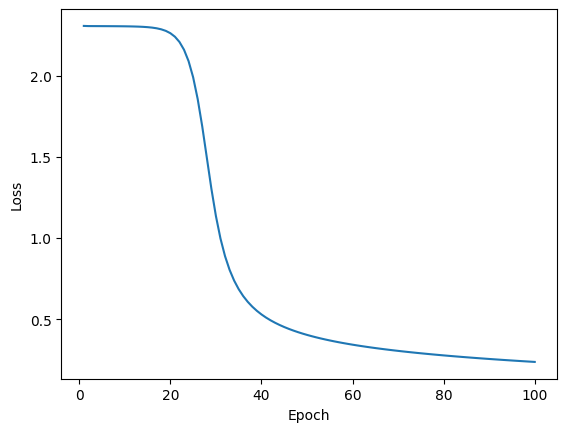

Test Accuracy: 0.9025


In [77]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target
X = X.to_numpy().astype(np.float32) / 255.0
y = y.to_numpy()

test_size = 0.2
X_train = X[int(len(X)*test_size):]
y_train = y[int(len(y)*test_size):]
X_test = X[:int(len(X)*test_size)]
y_test = y[:int(len(y)*test_size)]

X_train = X_train[:2000]
y_train = y_train[:2000]
X_test = X_test[:400]
y_test = y_test[:400]
train_dataset = MNISTDataset(X_train, y_train)
test_dataset = MNISTDataset(X_test, y_test)


# ---- Tích hợp tiền xử lý ----
# sử dụng kỹ thuật whitening
preprocessor = Preprocess(method='whiten', epsilon=0.1)
X_train_processed = preprocessor.fit_transform(X_train)  # X_train có shape (n_samples, 784)
X_test_processed = preprocessor.transform(X_test)

# Reshape về (n_samples, 1, 28, 28)
X_train_processed = X_train_processed.reshape(-1, 1, 28, 28)
X_test_processed = X_test_processed.reshape(-1, 1, 28, 28)

train_dataset = MNISTDataset(X_train_processed, y_train)
test_dataset = MNISTDataset(X_test_processed, y_test)


# Ham kich hoat ReLU
cfg = [
    [4, 3, 1, 1],
    'ReLU',
    'M',
]

dataloader = Dataloader(train_dataset, 64)
model = MNISTModel(1, 10, (28, 28), cfg, init = 'default')
loss_fn = CrossEntropyLoss()
optimizer = SGD(model, 0.0001)

EPOCHS = 100
losses = []

for epoch in range(EPOCHS):
    list_loss = []
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        model.backward(y_pred, batch_y)
        optimizer.step()
        optimizer.zero_grad()
        list_loss.append(loss)
    losses.append(sum(list_loss) / len(list_loss))
    print(f'Epoch {epoch+1}/{EPOCHS} | Loss: {sum(list_loss)/len(list_loss)}')

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.eval()
y_pred = model(X_test_processed)  # dữ liệu test đã được tiền xử lý và reshape
y_pred = np.argmax(y_pred, axis=1)
y_test = np.array(y_test).astype(int)
print("Test Accuracy:", np.mean(y_pred == y_test))

Epoch 1/100 | Loss: 2.3111975763219084
Epoch 2/100 | Loss: 2.310006798439088
Epoch 3/100 | Loss: 2.3097892450416224
Epoch 4/100 | Loss: 2.3094891135066398
Epoch 5/100 | Loss: 2.3090621494318184
Epoch 6/100 | Loss: 2.308433763084566
Epoch 7/100 | Loss: 2.3074952100026813
Epoch 8/100 | Loss: 2.3060794999146452
Epoch 9/100 | Loss: 2.303934866652125
Epoch 10/100 | Loss: 2.300697791655343
Epoch 11/100 | Loss: 2.2958419006363284
Epoch 12/100 | Loss: 2.288639273239163
Epoch 13/100 | Loss: 2.2781231276413427
Epoch 14/100 | Loss: 2.2630933200414365
Epoch 15/100 | Loss: 2.2421739458242773
Epoch 16/100 | Loss: 2.213907232663985
Epoch 17/100 | Loss: 2.1769227470532666
Epoch 18/100 | Loss: 2.130099917587855
Epoch 19/100 | Loss: 2.072751828131324
Epoch 20/100 | Loss: 2.004810117363576
Epoch 21/100 | Loss: 1.9270120633560117
Epoch 22/100 | Loss: 1.8409937360773614
Epoch 23/100 | Loss: 1.7492416962116515
Epoch 24/100 | Loss: 1.6548027413720343
Epoch 25/100 | Loss: 1.5608194237745103
Epoch 26/100 | Los

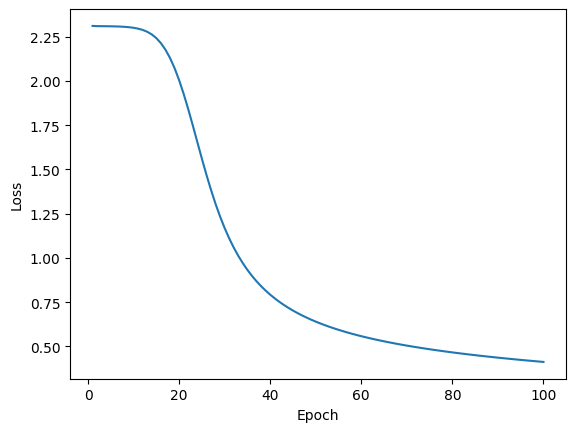

Test Accuracy: 0.9025


In [78]:
# Ham kich hoat Tanh
cfg = [
    [4, 3, 1, 1],
    'Tanh',
    'M',
]

dataloader = Dataloader(train_dataset, 64)
model = MNISTModel(1, 10, (28, 28), cfg, init = 'default')
loss_fn = CrossEntropyLoss()
optimizer = SGD(model, 0.0001)

EPOCHS = 100
losses = []

for epoch in range(EPOCHS):
    list_loss = []
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        model.backward(y_pred, batch_y)
        optimizer.step()
        optimizer.zero_grad()
        list_loss.append(loss)
    losses.append(sum(list_loss) / len(list_loss))
    print(f'Epoch {epoch+1}/{EPOCHS} | Loss: {sum(list_loss)/len(list_loss)}')

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.eval()
y_pred = model(X_test_processed)  # dữ liệu test đã được tiền xử lý và reshape
y_pred = np.argmax(y_pred, axis=1)
y_test = np.array(y_test).astype(int)
print("Test Accuracy:", np.mean(y_pred == y_test))

Epoch 1/100 | Loss: 2.3028689589317635
Epoch 2/100 | Loss: 2.302197889909128
Epoch 3/100 | Loss: 2.3016807795572167
Epoch 4/100 | Loss: 2.3012824052539744
Epoch 5/100 | Loss: 2.300975391244544
Epoch 6/100 | Loss: 2.300738514279797
Epoch 7/100 | Loss: 2.300555331380529
Epoch 8/100 | Loss: 2.3004132370174277
Epoch 9/100 | Loss: 2.3003025390527942
Epoch 10/100 | Loss: 2.300215821098739
Epoch 11/100 | Loss: 2.3001473945879005
Epoch 12/100 | Loss: 2.3000929194322475
Epoch 13/100 | Loss: 2.300049095562486
Epoch 14/100 | Loss: 2.3000133723529506
Epoch 15/100 | Loss: 2.299983839728126
Epoch 16/100 | Loss: 2.299959030959646
Epoch 17/100 | Loss: 2.299937823780374
Epoch 18/100 | Loss: 2.299919311904276
Epoch 19/100 | Loss: 2.299902863330602
Epoch 20/100 | Loss: 2.2998879441170152
Epoch 21/100 | Loss: 2.2998742041903264
Epoch 22/100 | Loss: 2.299861481180836
Epoch 23/100 | Loss: 2.299849509252132
Epoch 24/100 | Loss: 2.2998380575790236
Epoch 25/100 | Loss: 2.299827016857439
Epoch 26/100 | Loss: 2.

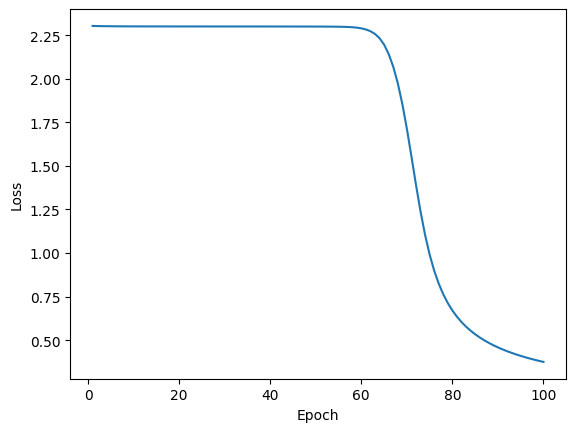

Test Accuracy: 0.89


In [79]:
# Ham kich hoat Leaky ReLU
cfg = [
    [4, 3, 1, 1],
    'LR',
    'M',
]

dataloader = Dataloader(train_dataset, 64)
model = MNISTModel(1, 10, (28, 28), cfg, init = 'default')
loss_fn = CrossEntropyLoss()
optimizer = SGD(model, 0.0001)

EPOCHS = 100
losses = []

for epoch in range(EPOCHS):
    list_loss = []
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        model.backward(y_pred, batch_y)
        optimizer.step()
        optimizer.zero_grad()
        list_loss.append(loss)
    losses.append(sum(list_loss) / len(list_loss))
    print(f'Epoch {epoch+1}/{EPOCHS} | Loss: {sum(list_loss)/len(list_loss)}')

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.eval()
y_pred = model(X_test_processed)  # dữ liệu test đã được tiền xử lý và reshape
y_pred = np.argmax(y_pred, axis=1)
y_test = np.array(y_test).astype(int)
print("Test Accuracy:", np.mean(y_pred == y_test))

Epoch 1/100 | Loss: 2.4906709485750587
Epoch 2/100 | Loss: 2.4818442073882867
Epoch 3/100 | Loss: 2.4744987294418115
Epoch 4/100 | Loss: 2.4676758812201536
Epoch 5/100 | Loss: 2.4612675640135686
Epoch 6/100 | Loss: 2.455176793278076
Epoch 7/100 | Loss: 2.449302890369793
Epoch 8/100 | Loss: 2.4435208815439653
Epoch 9/100 | Loss: 2.4376585250025515
Epoch 10/100 | Loss: 2.431487656405516
Epoch 11/100 | Loss: 2.4246707850438414
Epoch 12/100 | Loss: 2.416711604261934
Epoch 13/100 | Loss: 2.406862059359655
Epoch 14/100 | Loss: 2.39400951839745
Epoch 15/100 | Loss: 2.3764687951157226
Epoch 16/100 | Loss: 2.3517354682005025
Epoch 17/100 | Loss: 2.3161849864483237
Epoch 18/100 | Loss: 2.264669840076492
Epoch 19/100 | Loss: 2.190385579535516
Epoch 20/100 | Loss: 2.085390375929302
Epoch 21/100 | Loss: 1.94267161185295
Epoch 22/100 | Loss: 1.760819810219992
Epoch 23/100 | Loss: 1.55044414976746
Epoch 24/100 | Loss: 1.335667218274657
Epoch 25/100 | Loss: 1.1431621187405607
Epoch 26/100 | Loss: 0.98

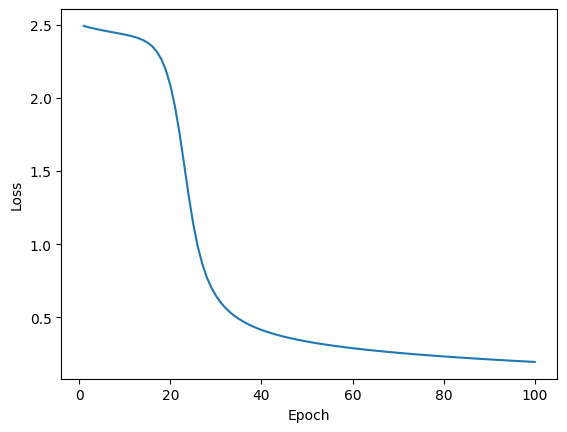

Test Accuracy: 0.9175


In [81]:
# Ham kich hoat ELU
cfg = [
    [4, 3, 1, 1],
    'ELU',
    'M',
]

dataloader = Dataloader(train_dataset, 64)
model = MNISTModel(1, 10, (28, 28), cfg, init = 'default')
loss_fn = CrossEntropyLoss()
optimizer = SGD(model, 0.0001)

EPOCHS = 100
losses = []

for epoch in range(EPOCHS):
    list_loss = []
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        model.backward(y_pred, batch_y)
        optimizer.step()
        optimizer.zero_grad()
        list_loss.append(loss)
    losses.append(sum(list_loss) / len(list_loss))
    print(f'Epoch {epoch+1}/{EPOCHS} | Loss: {sum(list_loss)/len(list_loss)}')

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.eval()
y_pred = model(X_test_processed)  # dữ liệu test đã được tiền xử lý và reshape
y_pred = np.argmax(y_pred, axis=1)
y_test = np.array(y_test).astype(int)
print("Test Accuracy:", np.mean(y_pred == y_test))

Epoch 1/100 | Loss: 2.3026217468875867
Epoch 2/100 | Loss: 2.300847642479959
Epoch 3/100 | Loss: 2.300010193188282
Epoch 4/100 | Loss: 2.299068824840733
Epoch 5/100 | Loss: 2.29756297975124
Epoch 6/100 | Loss: 2.2949559944653677
Epoch 7/100 | Loss: 2.29038701365552
Epoch 8/100 | Loss: 2.28231713530661
Epoch 9/100 | Loss: 2.268077692889685
Epoch 10/100 | Loss: 2.2435480761978193
Epoch 11/100 | Loss: 2.2051579797980283
Epoch 12/100 | Loss: 2.1499360016239177
Epoch 13/100 | Loss: 2.0718143079529403
Epoch 14/100 | Loss: 1.9650980359286647
Epoch 15/100 | Loss: 1.8289780680643248
Epoch 16/100 | Loss: 1.6690820891464162
Epoch 17/100 | Loss: 1.4983569066788487
Epoch 18/100 | Loss: 1.332884058750285
Epoch 19/100 | Loss: 1.18531954095255
Epoch 20/100 | Loss: 1.0613498993140238
Epoch 21/100 | Loss: 0.9605199674186967
Epoch 22/100 | Loss: 0.8793659261786875
Epoch 23/100 | Loss: 0.8138576486529115
Epoch 24/100 | Loss: 0.7604551876170995
Epoch 25/100 | Loss: 0.7163769765719152
Epoch 26/100 | Loss: 0

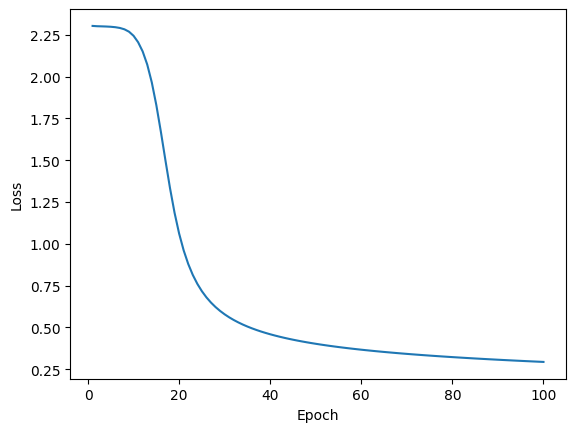

Test Accuracy: 0.8925


In [84]:
# ---- Tích hợp tiền xử lý ----
# sử dụng kỹ thuật center
preprocessor = Preprocess(method='center', epsilon=0.1)
X_train_processed = preprocessor.fit_transform(X_train)  # X_train có shape (n_samples, 784)
X_test_processed = preprocessor.transform(X_test)

# Reshape về (n_samples, 1, 28, 28)
X_train_processed = X_train_processed.reshape(-1, 1, 28, 28)
X_test_processed = X_test_processed.reshape(-1, 1, 28, 28)

train_dataset = MNISTDataset(X_train_processed, y_train)
test_dataset = MNISTDataset(X_test_processed, y_test)


# Ham kich hoat ReLU
cfg = [
    [4, 3, 1, 1],
    'ReLU',
    'M',
]

dataloader = Dataloader(train_dataset, 64)
model = MNISTModel(1, 10, (28, 28), cfg, init = 'default')
loss_fn = CrossEntropyLoss()
optimizer = SGD(model, 0.0001)

EPOCHS = 100
losses = []

for epoch in range(EPOCHS):
    list_loss = []
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        model.backward(y_pred, batch_y)
        optimizer.step()
        optimizer.zero_grad()
        list_loss.append(loss)
    losses.append(sum(list_loss) / len(list_loss))
    print(f'Epoch {epoch+1}/{EPOCHS} | Loss: {sum(list_loss)/len(list_loss)}')

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.eval()
y_pred = model(X_test_processed)  # dữ liệu test đã được tiền xử lý và reshape
y_pred = np.argmax(y_pred, axis=1)
y_test = np.array(y_test).astype(int)
print("Test Accuracy:", np.mean(y_pred == y_test))

Epoch 1/100 | Loss: 2.311034126529881
Epoch 2/100 | Loss: 2.3104200303615663
Epoch 3/100 | Loss: 2.310157821282167
Epoch 4/100 | Loss: 2.3098941335596215
Epoch 5/100 | Loss: 2.3095828090837913
Epoch 6/100 | Loss: 2.309195422979653
Epoch 7/100 | Loss: 2.308706542640485
Epoch 8/100 | Loss: 2.3080443140445457
Epoch 9/100 | Loss: 2.307117213988648
Epoch 10/100 | Loss: 2.305793223016507
Epoch 11/100 | Loss: 2.303878084498761
Epoch 12/100 | Loss: 2.301088380510736
Epoch 13/100 | Loss: 2.2970106847577934
Epoch 14/100 | Loss: 2.291037687622767
Epoch 15/100 | Loss: 2.282289462048169
Epoch 16/100 | Loss: 2.269503667125647
Epoch 17/100 | Loss: 2.2508985919623
Epoch 18/100 | Loss: 2.22402581324206
Epoch 19/100 | Loss: 2.1856599644886763
Epoch 20/100 | Loss: 2.1318359785129406
Epoch 21/100 | Loss: 2.0582561657815868
Epoch 22/100 | Loss: 1.9614966369685383
Epoch 23/100 | Loss: 1.8450588524354674
Epoch 24/100 | Loss: 1.7137029468928013
Epoch 25/100 | Loss: 1.5746265018160128
Epoch 26/100 | Loss: 1.43

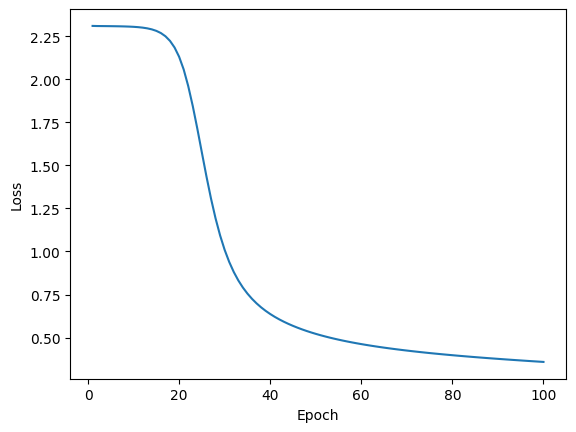

Test Accuracy: 0.88


In [85]:
# ---- Tích hợp tiền xử lý ----
# sử dụng kỹ thuật standardlize
preprocessor = Preprocess(method='standardlize', epsilon=0.1)
X_train_processed = preprocessor.fit_transform(X_train)  # X_train có shape (n_samples, 784)
X_test_processed = preprocessor.transform(X_test)

# Reshape về (n_samples, 1, 28, 28)
X_train_processed = X_train_processed.reshape(-1, 1, 28, 28)
X_test_processed = X_test_processed.reshape(-1, 1, 28, 28)

train_dataset = MNISTDataset(X_train_processed, y_train)
test_dataset = MNISTDataset(X_test_processed, y_test)


# Ham kich hoat ReLU
cfg = [
    [4, 3, 1, 1],
    'ReLU',
    'M',
]

dataloader = Dataloader(train_dataset, 64)
model = MNISTModel(1, 10, (28, 28), cfg, init = 'default')
loss_fn = CrossEntropyLoss()
optimizer = SGD(model, 0.0001)

EPOCHS = 100
losses = []

for epoch in range(EPOCHS):
    list_loss = []
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        model.backward(y_pred, batch_y)
        optimizer.step()
        optimizer.zero_grad()
        list_loss.append(loss)
    losses.append(sum(list_loss) / len(list_loss))
    print(f'Epoch {epoch+1}/{EPOCHS} | Loss: {sum(list_loss)/len(list_loss)}')

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.eval()
y_pred = model(X_test_processed)  # dữ liệu test đã được tiền xử lý và reshape
y_pred = np.argmax(y_pred, axis=1)
y_test = np.array(y_test).astype(int)
print("Test Accuracy:", np.mean(y_pred == y_test))

Epoch 1/100 | Loss: 2.304824103200936
Epoch 2/100 | Loss: 2.3030662293230764
Epoch 3/100 | Loss: 2.3030464308098377
Epoch 4/100 | Loss: 2.3030015327500704
Epoch 5/100 | Loss: 2.302961888580487
Epoch 6/100 | Loss: 2.3029298917606527
Epoch 7/100 | Loss: 2.302903141390228
Epoch 8/100 | Loss: 2.302878500100092
Epoch 9/100 | Loss: 2.302853444454831
Epoch 10/100 | Loss: 2.302825704915082
Epoch 11/100 | Loss: 2.302793381137748
Epoch 12/100 | Loss: 2.3027571208763042
Epoch 13/100 | Loss: 2.302714242949122
Epoch 14/100 | Loss: 2.3026632628609778
Epoch 15/100 | Loss: 2.3026031312652417
Epoch 16/100 | Loss: 2.3025325727545716
Epoch 17/100 | Loss: 2.3024474413870935
Epoch 18/100 | Loss: 2.302344669476123
Epoch 19/100 | Loss: 2.3022189699654874
Epoch 20/100 | Loss: 2.3020637617730664
Epoch 21/100 | Loss: 2.3018714300843515
Epoch 22/100 | Loss: 2.3016327266631564
Epoch 23/100 | Loss: 2.301335498046758
Epoch 24/100 | Loss: 2.3009647866748884
Epoch 25/100 | Loss: 2.3005015118606167
Epoch 26/100 | Loss

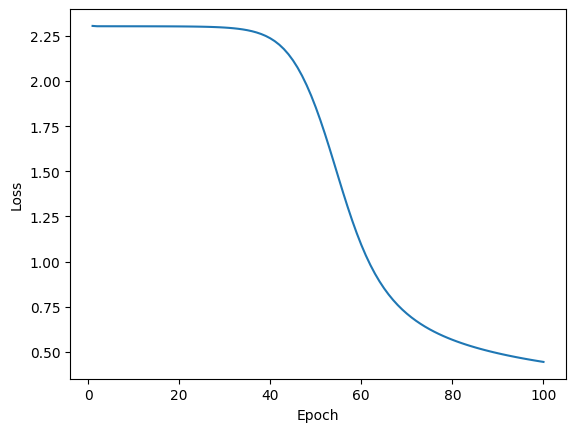

Test Accuracy: 0.855


In [86]:
# ---- Tích hợp tiền xử lý ----
# sử dụng kỹ thuật whiten
preprocessor = Preprocess(method='whiten', epsilon=0.1)
X_train_processed = preprocessor.fit_transform(X_train)  # X_train có shape (n_samples, 784)
X_test_processed = preprocessor.transform(X_test)

# Reshape về (n_samples, 1, 28, 28)
X_train_processed = X_train_processed.reshape(-1, 1, 28, 28)
X_test_processed = X_test_processed.reshape(-1, 1, 28, 28)

train_dataset = MNISTDataset(X_train_processed, y_train)
test_dataset = MNISTDataset(X_test_processed, y_test)


# Ham kich hoat ReLU
cfg = [
    [4, 3, 1, 1],
    'ReLU',
    'M',
]

dataloader = Dataloader(train_dataset, 64)
model = MNISTModel(1, 10, (28, 28), cfg, init = 'default')
loss_fn = CrossEntropyLoss()
optimizer = SGD(model, 0.0001)

EPOCHS = 100
losses = []

for epoch in range(EPOCHS):
    list_loss = []
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        model.backward(y_pred, batch_y)
        optimizer.step()
        optimizer.zero_grad()
        list_loss.append(loss)
    losses.append(sum(list_loss) / len(list_loss))
    print(f'Epoch {epoch+1}/{EPOCHS} | Loss: {sum(list_loss)/len(list_loss)}')

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.eval()
y_pred = model(X_test_processed)  # dữ liệu test đã được tiền xử lý và reshape
y_pred = np.argmax(y_pred, axis=1)
y_test = np.array(y_test).astype(int)
print("Test Accuracy:", np.mean(y_pred == y_test))

Epoch 1/100 | Loss: 2.302615970265795
Epoch 2/100 | Loss: 2.301331065180451
Epoch 3/100 | Loss: 2.3011816486834937
Epoch 4/100 | Loss: 2.3010807266141824
Epoch 5/100 | Loss: 2.300930456925881
Epoch 6/100 | Loss: 2.300702470629788
Epoch 7/100 | Loss: 2.300359139663295
Epoch 8/100 | Loss: 2.2998327809899837
Epoch 9/100 | Loss: 2.299024514392551
Epoch 10/100 | Loss: 2.2977753063033513
Epoch 11/100 | Loss: 2.295815838300342
Epoch 12/100 | Loss: 2.2927049743462886
Epoch 13/100 | Loss: 2.2877109814132637
Epoch 14/100 | Loss: 2.2795937117989835
Epoch 15/100 | Loss: 2.2662190708741523
Epoch 16/100 | Loss: 2.2440336604415747
Epoch 17/100 | Loss: 2.2072922913341144
Epoch 18/100 | Loss: 2.1471814081588882
Epoch 19/100 | Loss: 2.052363545547271
Epoch 20/100 | Loss: 1.9140629609389437
Epoch 21/100 | Loss: 1.7308495522403575
Epoch 22/100 | Loss: 1.519547367638313
Epoch 23/100 | Loss: 1.3104053291486983
Epoch 24/100 | Loss: 1.1290189137687328
Epoch 25/100 | Loss: 0.9847804558294774
Epoch 26/100 | Los

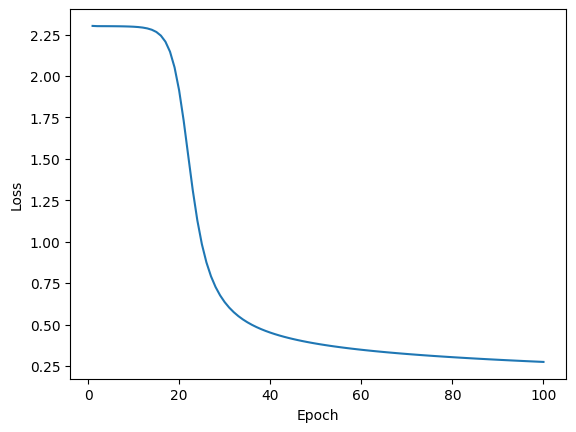

Test Accuracy: 0.88


In [87]:
# ---- Tích hợp tiền xử lý ----
# sử dụng kỹ thuật minmax
preprocessor = Preprocess(method='minmax', epsilon=0.1)
X_train_processed = preprocessor.fit_transform(X_train)  # X_train có shape (n_samples, 784)
X_test_processed = preprocessor.transform(X_test)

# Reshape về (n_samples, 1, 28, 28)
X_train_processed = X_train_processed.reshape(-1, 1, 28, 28)
X_test_processed = X_test_processed.reshape(-1, 1, 28, 28)

train_dataset = MNISTDataset(X_train_processed, y_train)
test_dataset = MNISTDataset(X_test_processed, y_test)


# Ham kich hoat ReLU
cfg = [
    [4, 3, 1, 1],
    'ReLU',
    'M',
]

dataloader = Dataloader(train_dataset, 64)
model = MNISTModel(1, 10, (28, 28), cfg, init = 'default')
loss_fn = CrossEntropyLoss()
optimizer = SGD(model, 0.0001)

EPOCHS = 100
losses = []

for epoch in range(EPOCHS):
    list_loss = []
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        model.backward(y_pred, batch_y)
        optimizer.step()
        optimizer.zero_grad()
        list_loss.append(loss)
    losses.append(sum(list_loss) / len(list_loss))
    print(f'Epoch {epoch+1}/{EPOCHS} | Loss: {sum(list_loss)/len(list_loss)}')

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.eval()
y_pred = model(X_test_processed)  # dữ liệu test đã được tiền xử lý và reshape
y_pred = np.argmax(y_pred, axis=1)
y_test = np.array(y_test).astype(int)
print("Test Accuracy:", np.mean(y_pred == y_test))

Epoch 1/100 | Loss: 2.3587523123337064
Epoch 2/100 | Loss: 2.274603744175339
Epoch 3/100 | Loss: 2.214784804791048
Epoch 4/100 | Loss: 2.1442925184995323
Epoch 5/100 | Loss: 2.056409611212464
Epoch 6/100 | Loss: 1.9482277079456436
Epoch 7/100 | Loss: 1.822703041090616
Epoch 8/100 | Loss: 1.687864759427253
Epoch 9/100 | Loss: 1.5532073711742425
Epoch 10/100 | Loss: 1.426191129557536
Epoch 11/100 | Loss: 1.311247521054082
Epoch 12/100 | Loss: 1.2101719659299246
Epoch 13/100 | Loss: 1.1228337689035106
Epoch 14/100 | Loss: 1.048065834828237
Epoch 15/100 | Loss: 0.9842191343017767
Epoch 16/100 | Loss: 0.929594902045609
Epoch 17/100 | Loss: 0.8826634713626139
Epoch 18/100 | Loss: 0.8420963059900297
Epoch 19/100 | Loss: 0.8068027609262407
Epoch 20/100 | Loss: 0.7758898335673334
Epoch 21/100 | Loss: 0.7486353992924291
Epoch 22/100 | Loss: 0.7244472194401355
Epoch 23/100 | Loss: 0.7028530680737458
Epoch 24/100 | Loss: 0.6834616712408077
Epoch 25/100 | Loss: 0.6659508577565151
Epoch 26/100 | Los

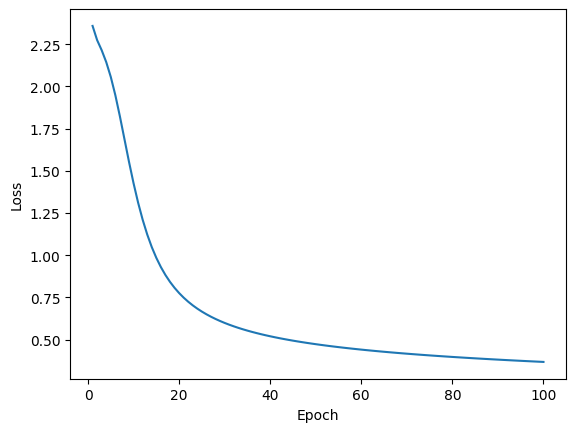

Test Accuracy: 0.895


In [88]:
# ---- Tích hợp tiền xử lý ----
# sử dụng kỹ thuật standardlize
preprocessor = Preprocess(method='standardlize', epsilon=0.1)
X_train_processed = preprocessor.fit_transform(X_train)  # X_train có shape (n_samples, 784)
X_test_processed = preprocessor.transform(X_test)

# Reshape về (n_samples, 1, 28, 28)
X_train_processed = X_train_processed.reshape(-1, 1, 28, 28)
X_test_processed = X_test_processed.reshape(-1, 1, 28, 28)

train_dataset = MNISTDataset(X_train_processed, y_train)
test_dataset = MNISTDataset(X_test_processed, y_test)


# Ham kich hoat tanh
cfg = [
    [4, 3, 1, 1],
    'Tanh',
    'M',
]

dataloader = Dataloader(train_dataset, 64)
model = MNISTModel(1, 10, (28, 28), cfg, init = 'xavier')
loss_fn = CrossEntropyLoss()
optimizer = SGD(model, 0.0001)

EPOCHS = 100
losses = []

for epoch in range(EPOCHS):
    list_loss = []
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        model.backward(y_pred, batch_y)
        optimizer.step()
        optimizer.zero_grad()
        list_loss.append(loss)
    losses.append(sum(list_loss) / len(list_loss))
    print(f'Epoch {epoch+1}/{EPOCHS} | Loss: {sum(list_loss)/len(list_loss)}')

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.eval()
y_pred = model(X_test_processed)  # dữ liệu test đã được tiền xử lý và reshape
y_pred = np.argmax(y_pred, axis=1)
y_test = np.array(y_test).astype(int)
print("Test Accuracy:", np.mean(y_pred == y_test))

Epoch 1/100 | Loss: 2.274484768196024
Epoch 2/100 | Loss: 1.7647579783903249
Epoch 3/100 | Loss: 1.4313434805455016
Epoch 4/100 | Loss: 1.1838250579426781
Epoch 5/100 | Loss: 1.0060659563373608
Epoch 6/100 | Loss: 0.8790085484380107
Epoch 7/100 | Loss: 0.7865629182176096
Epoch 8/100 | Loss: 0.7173324262344933
Epoch 9/100 | Loss: 0.6639785123889064
Epoch 10/100 | Loss: 0.6217720117076755
Epoch 11/100 | Loss: 0.5876125680939625
Epoch 12/100 | Loss: 0.5594400690021467
Epoch 13/100 | Loss: 0.5358288699919813
Epoch 14/100 | Loss: 0.5158723011038533
Epoch 15/100 | Loss: 0.4986398463910482
Epoch 16/100 | Loss: 0.48351981234235436
Epoch 17/100 | Loss: 0.4701569605352199
Epoch 18/100 | Loss: 0.45822342824352
Epoch 19/100 | Loss: 0.4474955939295867
Epoch 20/100 | Loss: 0.4377771445954706
Epoch 21/100 | Loss: 0.42892114699258815
Epoch 22/100 | Loss: 0.4208027319593261
Epoch 23/100 | Loss: 0.41333057563712117
Epoch 24/100 | Loss: 0.40640969957770157
Epoch 25/100 | Loss: 0.39998287104134556
Epoch 2

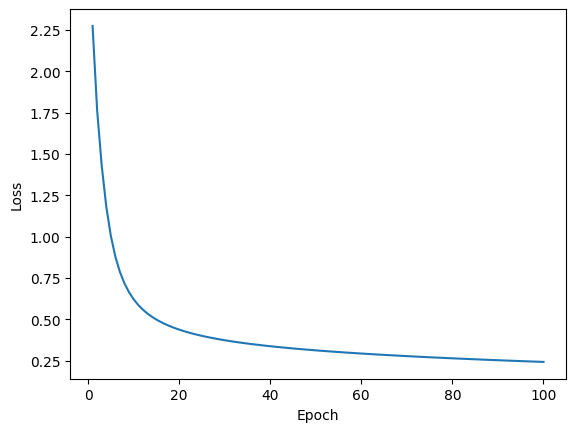

Test Accuracy: 0.8925


In [89]:
# ---- Tích hợp tiền xử lý ----
# sử dụng kỹ thuật standardlize
preprocessor = Preprocess(method='standardlize', epsilon=0.1)
X_train_processed = preprocessor.fit_transform(X_train)  # X_train có shape (n_samples, 784)
X_test_processed = preprocessor.transform(X_test)

# Reshape về (n_samples, 1, 28, 28)
X_train_processed = X_train_processed.reshape(-1, 1, 28, 28)
X_test_processed = X_test_processed.reshape(-1, 1, 28, 28)

train_dataset = MNISTDataset(X_train_processed, y_train)
test_dataset = MNISTDataset(X_test_processed, y_test)


# Ham kich hoat ReLU
cfg = [
    [4, 3, 1, 1],
    'ReLU',
    'M',
]

dataloader = Dataloader(train_dataset, 64)
model = MNISTModel(1, 10, (28, 28), cfg, init = 'he')
loss_fn = CrossEntropyLoss()
optimizer = SGD(model, 0.0001)

EPOCHS = 100
losses = []

for epoch in range(EPOCHS):
    list_loss = []
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        model.backward(y_pred, batch_y)
        optimizer.step()
        optimizer.zero_grad()
        list_loss.append(loss)
    losses.append(sum(list_loss) / len(list_loss))
    print(f'Epoch {epoch+1}/{EPOCHS} | Loss: {sum(list_loss)/len(list_loss)}')

plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.eval()
y_pred = model(X_test_processed)  # dữ liệu test đã được tiền xử lý và reshape
y_pred = np.argmax(y_pred, axis=1)
y_test = np.array(y_test).astype(int)
print("Test Accuracy:", np.mean(y_pred == y_test))